**Ciuffreda Luigi MATRICOLA:351898**
# Traccia A2 - Predizione del prezzo di automobili


## Importing libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder


## Loading the data


In [2]:
car_data = pd.read_csv("OneDrive - Università Politecnica delle Marche/Desktop/UNITORV/ML/Progetti_ML/car_prices.csv")
car_data.head()

,manufacturer,model,year,transmission,mileage,fuelType,mpg,engineSize,price
0,Audi,A1,2017,Manual,15735,Petrol,55.4,1.4,12500
1,Audi,A6,2016,Automatic,36203,Diesel,64.2,2.0,16500
2,Audi,A1,2016,Manual,29946,Petrol,55.4,1.4,11000
3,Audi,A4,2017,Automatic,25952,Diesel,67.3,2.0,16800
4,Audi,A3,2019,Manual,1998,Petrol,49.6,1.0,17300


In [3]:
x = car_data.drop('price', axis=1)  # Features
y = car_data['price']  # Target variable

## Training Set and Test Set

In [4]:
# Suddivisione del dataset in set di addestramento e test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)


In [5]:
#Concateniamo le x train e le y train per formare il training set che andremo ad analizzare.
car_data = pd.concat([x_train, y_train], axis=1)

# Preprocessing

In [6]:
car_data.describe()

,year,mileage,mpg,engineSize,price
count,33044.000000,33044.000000,33044.000000,33044.000000,33044.000000
mean,2017.096962,23696.463443,55.664756,1.961470,21735.636636
std,2.260756,22517.810500,21.159772,0.601724,11787.343055
min,1970.000000,1.000000,1.100000,0.000000,650.000000
25%,2016.000000,6216.500000,45.600000,1.500000,13900.000000
50%,2017.000000,17419.500000,54.300000,2.000000,19750.000000
75%,2019.000000,34091.250000,64.200000,2.100000,26854.000000
max,2020.000000,323000.000000,470.800000,6.600000,149948.000000


In [7]:
#Controlliamo le statistiche del dataset
car_data.info()
#Andiamo a controllare l'eventuale presenta di righe duplicate
car_data.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 33044 entries, 12671 to 14000
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  33044 non-null  object 
 1   model         33044 non-null  object 
 2   year          33044 non-null  int64  
 3   transmission  33044 non-null  object 
 4   mileage       33044 non-null  int64  
 5   fuelType      33044 non-null  object 
 6   mpg           33044 non-null  float64
 7   engineSize    33044 non-null  float64
 8   price         33044 non-null  int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 2.5+ MB


387

**Vista la presenza di righe duplicate andiamo ad eliminarle.**

In [8]:
#Eliminiamo i duplicati
car_data = car_data.drop_duplicates()
#andiamo a verificare se la colonna price contiene valori nulli
null_values_price = car_data['price'].isnull().sum()
display(null_values_price)

0

In [9]:
# Visualizza il conteggio di unicità per ogni feature
unique_counts = car_data.nunique()
print(unique_counts)

manufacturer        4
model              95
year               26
transmission        4
mileage         20880
fuelType            5
mpg               168
engineSize         38
price            7921
dtype: int64


**Andiamo a rimuovere la colonna 'model' poiché ha un gran numero di valori unici e non risulta rilevamnte per il modello.**

In [10]:
df = car_data.drop(labels='model', axis=1)

In [11]:
#Controlliamo la presenza di valori nulli nelle colonne
df.isna().sum()

manufacturer    0
year            0
transmission    0
mileage         0
fuelType        0
mpg             0
engineSize      0
price           0
dtype: int64

## Matrice di Correlazione

**Creiamo la matrice di correlazione con solo le colonne numeriche per andare a stabilire quale delle feature solo correlate linearmente al nostro target.**

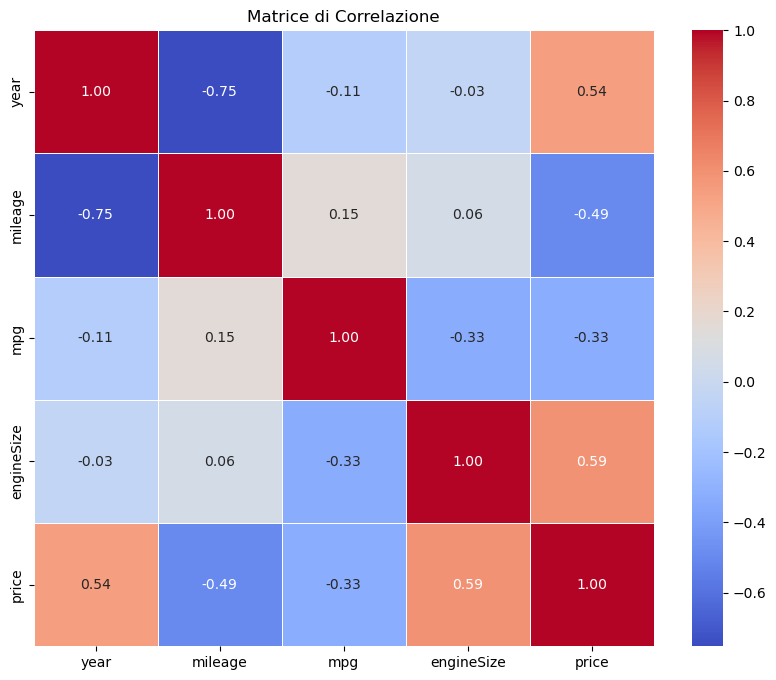

In [12]:

# Seleziona solo colonne numeriche
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Calcola la matrice di correlazione solo per le colonne numeriche
correlation_matrix = numeric_columns.corr()

# Crea un heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Matrice di Correlazione")
plt.show()

## Plot delle distribuzioni delle feature più importanti

Text(0.5, 1.0, 'Car Price Distribution Plot')

<Figure size 1100x500 with 0 Axes>

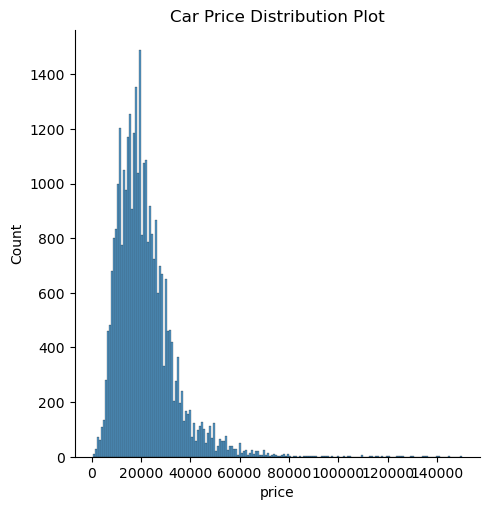

In [13]:
#Price Distribution Plot
plt.figure(figsize=[11,5])
sns.displot(df['price'])
plt.title('Car Price Distribution Plot')


Text(0.5, 1.0, 'Car Year Distribution Plot')

<Figure size 1700x500 with 0 Axes>

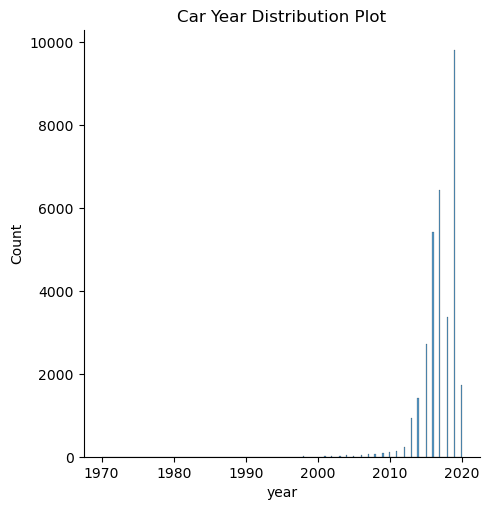

In [14]:

#Year Distribution Plot
plt.figure(figsize=[17,5])
sns.displot(df['year'])
plt.title('Car Year Distribution Plot')



Text(0.5, 1.0, 'Car Mileage Distribution Plot')

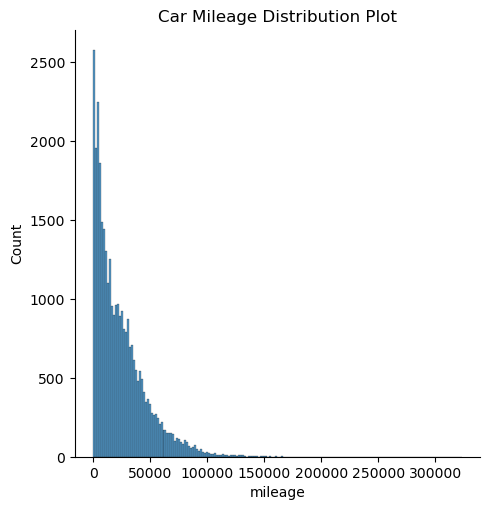

In [15]:
#Mileage Distribution Plot
sns.displot(df['mileage'])
plt.title('Car Mileage Distribution Plot')


Text(0.5, 1.0, 'engineSize Distribution Plot')

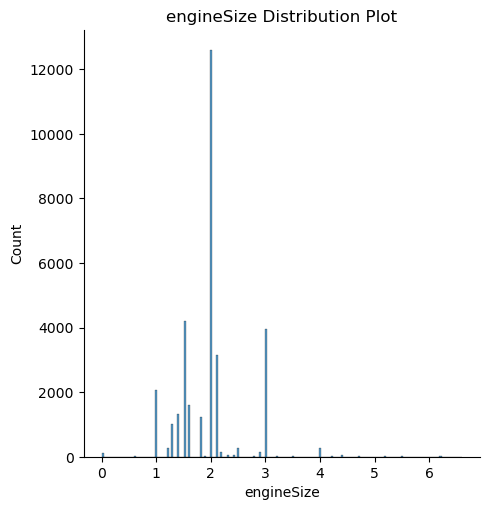

In [16]:

#engineSize Distribution Plot
sns.displot(df['engineSize'])
plt.title('engineSize Distribution Plot')

**Come possiamo notare dai grafici precedenti, in tutte le features abbiamo dei valori di outliers che adesso andiamo ad eliminare.**

In [17]:
# Crea un nuovo DataFrame con la condizione che i prezzi devono essere compresi tra 0 e 70.000
data_1 = df[(df['price'] >= 0) & (df['price'] <= 70000)]


Text(0.5, 1.0, 'Car Price Distribution Plot')

<Figure size 1100x500 with 0 Axes>

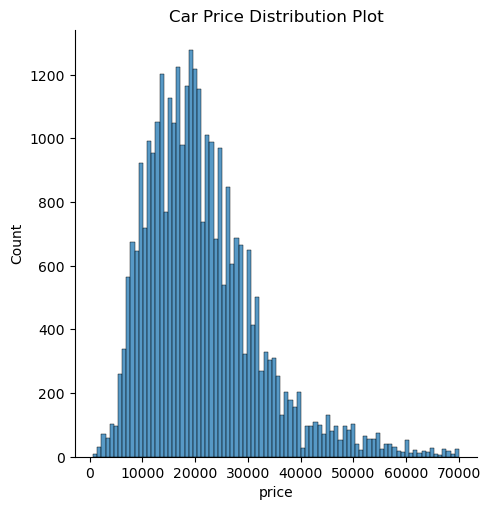

In [18]:
#Price Distribution Plot
plt.figure(figsize=[11,5])
sns.displot(data_1['price'])
plt.title('Car Price Distribution Plot')

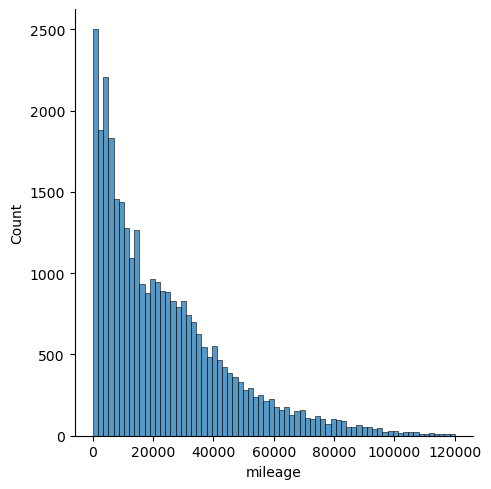

In [19]:

# Crea un nuovo DataFrame con la condizione che i valori della colonna 'mileage' devono essere compresi tra 0 e 90.000
data_2 = data_1[(data_1['mileage'] >= 0) & (data_1['mileage'] <= 120000)]

# mileage new Distribution Plot
sns.displot(data_2['mileage'])

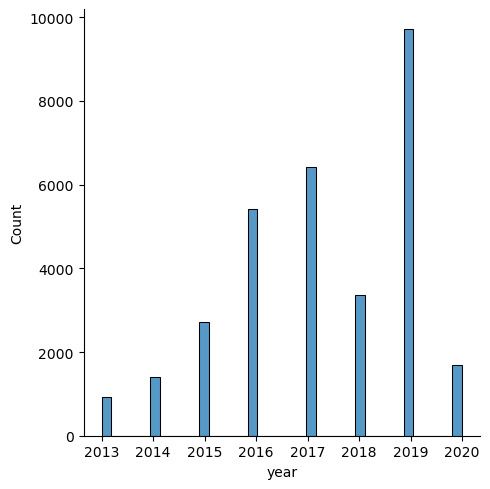

In [20]:

# Crea un nuovo DataFrame con la condizione che i valori della colonna 'year' devono essere compresi tra 2013 e 2020
data_3 = data_2[(data_2['year'] >= 2013) & (data_2['year'] <= 2020)]

# year new Distribution Plot
sns.displot(data_3['year'])

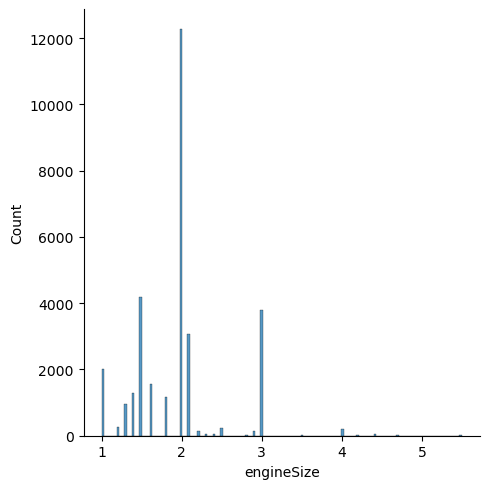

In [21]:

# Crea un nuovo DataFrame con la condizione che i valori della colonna 'engineSize' devono essere compresi tra 1 e 6
data_4 = data_3[(data_3['engineSize'] >= 1) & (data_3['engineSize'] <= 6)]


# engineSize new Distribution Plot
sns.displot(data_4['engineSize'])

In [22]:
# Reimposta l'indice per evitare di mantenere il vecchio indice come nuova colonna
cleaned_data = data_4.reset_index(drop=True)

# Verifica le statistiche descrittive dopo la pulizia e il reset dell'indice
cleaned_data.describe()

,year,mileage,mpg,engineSize,price
count,31502.000000,31502.000000,31502.000000,31502.000000,31502.000000
mean,2017.288998,22402.064758,55.633718,1.952171,21734.021078
std,1.763401,20003.779884,15.851904,0.562253,10564.062135
min,2013.000000,1.000000,1.100000,1.000000,2470.000000
25%,2016.000000,6285.000000,46.300000,1.500000,14131.000000
50%,2017.000000,17000.000000,55.400000,2.000000,19924.000000
75%,2019.000000,32849.750000,64.200000,2.000000,26899.000000
max,2020.000000,120000.000000,470.800000,5.500000,70000.000000


Text(0.5, 1.0, 'Price and EngineV')

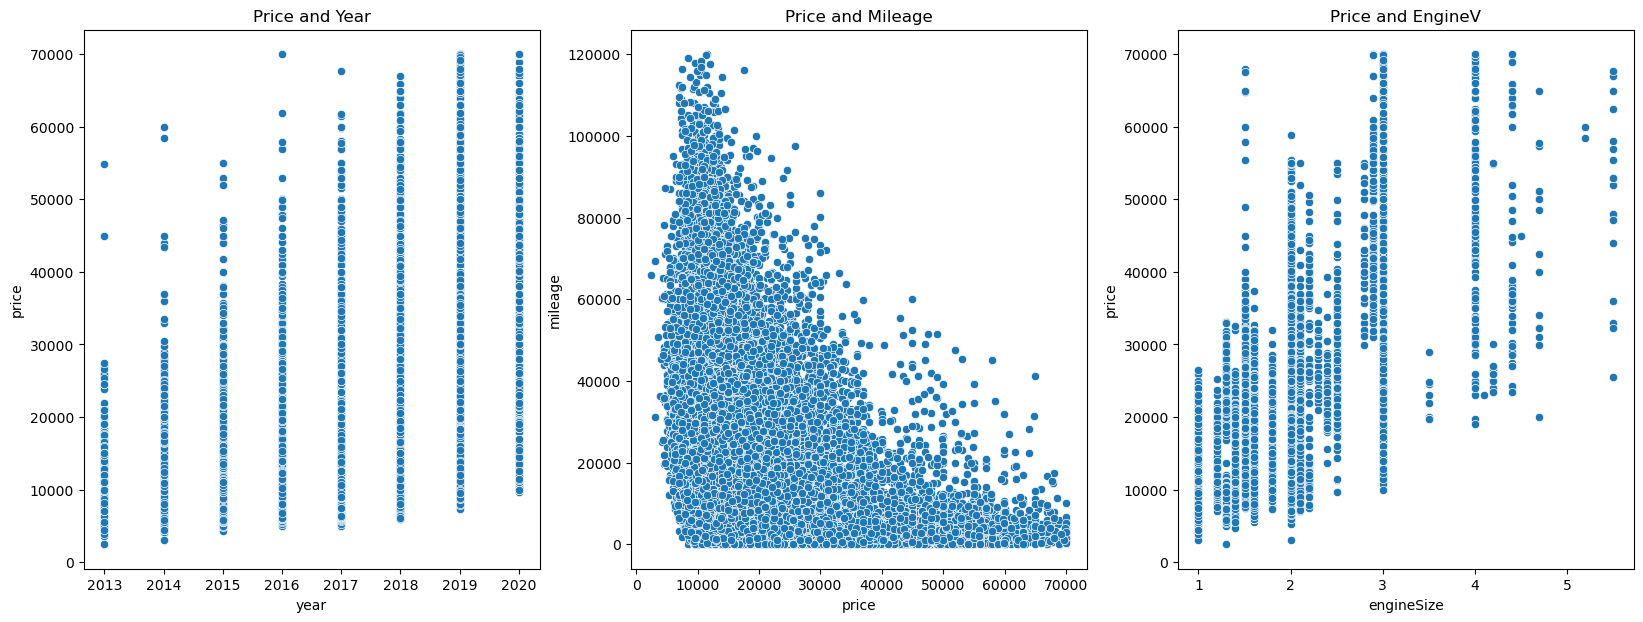

In [23]:
#Scatter Plot of independent variables vs dependent variables
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='year',y='price',data=cleaned_data)

plt.subplot(1,3,2)
plt.title("Price and Mileage")
sns.scatterplot(x='price',y='mileage',data=cleaned_data)

plt.subplot(1,3,3)
sns.scatterplot(y='price',x='engineSize',data=cleaned_data)
plt.title("Price and EngineV")

**Trasformiamo la colonna 'price' utilizzando il logaritmo per rendere la distribuzione più simmetrica**

In [24]:
log_price = np.log(cleaned_data['price'])

# Aggiungiamo la nuova colonna 'log_price' al nostro DataFrame
cleaned_data['log_price'] = log_price
cleaned_data.head()

,manufacturer,year,transmission,mileage,fuelType,mpg,engineSize,price,log_price
0,BMW,2015,Semi-Auto,31911,Diesel,57.6,2.0,17310,9.759040
1,Toyota,2018,Manual,8000,Petrol,56.5,1.0,9695,9.179366
2,Mercedes,2017,Manual,35421,Diesel,67.3,2.1,16498,9.710994
3,BMW,2019,Semi-Auto,7460,Diesel,65.7,2.0,26350,10.179224
4,BMW,2019,Semi-Auto,2538,Diesel,54.3,2.0,33990,10.433822


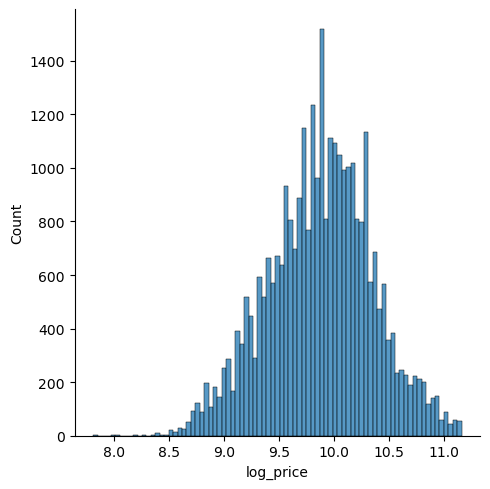

In [25]:
sns.displot(cleaned_data['log_price'])

In [26]:
#Eliminiamo la colonna price che verrà sostituita da 'log price'
cleaned_data = cleaned_data.drop(['price'],axis=1)

**Andiamo a codificare le colonne categoriche.**

In [27]:

# Label Encoding for categorical columns
temp_data = cleaned_data.copy()
# Codifica delle colonne categoriche usando Label Encoding
for col in temp_data.columns:
    # Verifica se la colonna è di tipo 'object' (categorica)
    if temp_data[col].dtypes == 'object':
        encoder = LabelEncoder()
         # Applica la codifica alla colonna
        temp_data[col] = encoder.fit_transform(temp_data[col])

# Calcola la correlazione tra le caratteristiche e la variabile target (log_price)
print('\n--Correlated Features with the target variable--\n')
print(abs(temp_data.corrwith(temp_data['log_price'])).sort_values(ascending=False)[1:])

# Creazione di variabili dummy usando One-Hot Encoding
data_with_dummies = pd.get_dummies(cleaned_data, drop_first=True)
data_with_dummies.head()



--Correlated Features with the target variable--

year            0.622664
engineSize      0.605718
mileage         0.521745
mpg             0.445504
manufacturer    0.279757
transmission    0.248496
fuelType        0.146769
dtype: float64


,year,mileage,mpg,engineSize,log_price,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2015,31911,57.6,2.0,9.759040,True,False,False,False,False,True,False,False,False,False
1,2018,8000,56.5,1.0,9.179366,False,False,True,True,False,False,False,False,False,True
2,2017,35421,67.3,2.1,9.710994,False,True,False,True,False,False,False,False,False,False
3,2019,7460,65.7,2.0,10.179224,True,False,False,False,False,True,False,False,False,False
4,2019,2538,54.3,2.0,10.433822,True,False,False,False,False,True,False,False,False,False


## Model Development


In [28]:
# Dividiamo le x_train e le y train codificate 
x_train=data_with_dummies.drop('log_price',axis=1)
y_train=data_with_dummies['log_price']


x_test_encoded = x_test.copy()
# Nel test set andiamoa d eliminare 'model'  che abbiamo tolto anche nel training set. 
if 'model' in x_test_encoded.columns:
    x_test_encoded.pop('model')

# Crea una copia dei dati
x_test_encoded_with_dummies = x_test_encoded.copy()

# Identifica colonne categoriche
categorical_columns = x_test_encoded_with_dummies.select_dtypes('object').columns

# Applica One-Hot Encoding alle colonne categoriche del test set 
x_test_encoded_with_dummies = pd.get_dummies(x_test_encoded_with_dummies, drop_first=True)
x_test_encoded_with_dummies.head()

,year,mileage,mpg,engineSize,manufacturer_BMW,manufacturer_Mercedes,manufacturer_Toyota,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
13280,2020,6,42.8,1.5,True,False,False,True,False,False,False,False,False,True
5203,2017,44738,58.9,2.0,False,False,False,True,False,False,False,False,False,False
4767,2019,6000,38.7,2.0,False,False,False,False,False,False,False,False,False,True
32821,2014,38986,64.2,2.1,False,True,False,True,False,False,False,False,False,False
8333,2013,29899,53.3,1.4,False,False,False,True,False,False,False,False,False,True


In [29]:
#applichiamo anche al Test Set il logaritmo del target 'Price'
y_test_log =np.log(y_test)

### Linear Regression Model

Test Set - MSE: 0.03416809397122965
Test Set - RMSE: 0.1848461359380543


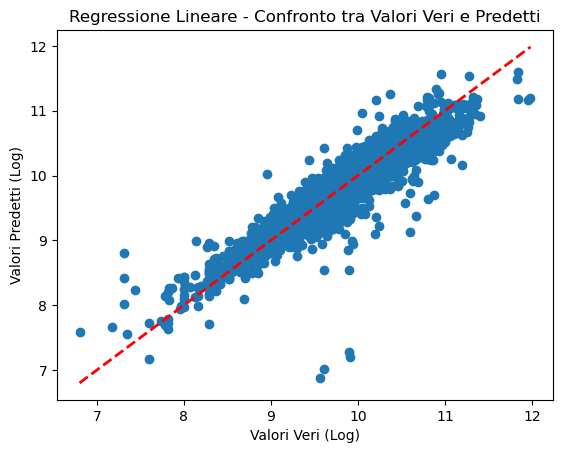

In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Costruzione del Modello
lr = LinearRegression()

# Addestramento del Modello
lr.fit(x_train, y_train)

# Riepilogo del Modello
y_pred_lr = lr.predict(x_test_encoded_with_dummies)

# Calcolo del Mean Squared Error (MSE) sul Set di Test
mse = mean_squared_error(y_test_log, y_pred_lr)
print("Test Set - MSE:", mse)

# Calcolo del Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Test Set - RMSE:", rmse)


# Grafico della regressione lineare
plt.scatter(y_test_log, y_pred_lr)
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], linestyle='--', color='red', linewidth=2)
plt.xlabel("Valori Veri (Log)")
plt.ylabel("Valori Predetti (Log)")
plt.title("Regressione Lineare - Confronto tra Valori Veri e Predetti")
plt.show()



### Random Forest Regressor Model

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definizione dei parametri da testare
'''param_grid = {
    'n_estimators': [50 ,100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}'''


# Creazione dell'oggetto GridSearchCV
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

# Addestramento del modello con la ricerca degli iperparametri
#grid_search.fit(x_train, y_train)

# Visualizzazione dei migliori parametri
#print("Migliori parametri:", grid_search.best_params_)

# Creazione del modello Random Forest con i parametri ottimizzati dalla Grid Search
rf = RandomForestRegressor(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=300)

# Addestramento del modello
rf.fit(x_train, y_train)

# Predizione sul Set di Test
y_pred_rf = rf.predict(x_test_encoded_with_dummies)

# Calcolo del Mean Squared Error (MSE) sul Set di Test
mse = mean_squared_error(y_test_log, y_pred_rf)
print("Test Set - MSE:", mse)

# Calcolo del Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Test Set - RMSE:", rmse)


Test Set - MSE: 0.027053982622290865
Test Set - RMSE: 0.16448094911657965


### Decision Tree Regressor Model

In [32]:

# Creazione e addestramento del modello DecisionTreeRegressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(x_train, y_train)

# Predizione sui dati di test
y_pred_test = tree.predict(x_test_encoded_with_dummies)

# Valutazione sui dati di test
mse_test = mean_squared_error(y_test_log, y_pred_test)
print("Test Set - MSE:", mse_test)
# Calcolo del Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_test)
print("Test Set - RMSE:", rmse)


Test Set - MSE: 0.034381548468734466
Test Set - RMSE: 0.1854226212432951


### KNN

In [33]:
from sklearn.neighbors import KNeighborsRegressor

# Costruzione del Modello KNN
knn = KNeighborsRegressor(n_neighbors=5)  

# Addestramento del Modello
knn.fit(x_train, y_train)

# Riepilogo del Modello
y_pred_knn = knn.predict(x_test_encoded_with_dummies)

# Calcolo del Mean Squared Error (MSE) sul Set di Test
mse_knn = mean_squared_error(y_test_log, y_pred_knn)
print("Test Set - MSE (KNN):", mse_knn)
# Calcolo del Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_knn)
print("Test Set - RMSE:", rmse)


Test Set - MSE (KNN): 0.1471041281328291
Test Set - RMSE: 0.38354155985085775


### Deep Neaural Network model

Epoch 1/50
788/788 [==============================] - 6s 5ms/step - loss: 30.1555 - val_loss: 0.2634
Epoch 2/50
788/788 [==============================] - 3s 4ms/step - loss: 2.3142 - val_loss: 0.1808
Epoch 3/50
788/788 [==============================] - 4s 5ms/step - loss: 1.6052 - val_loss: 0.1804
Epoch 4/50
788/788 [==============================] - 5s 6ms/step - loss: 1.2622 - val_loss: 0.1642
Epoch 5/50
788/788 [==============================] - 4s 5ms/step - loss: 1.0759 - val_loss: 0.1626
Epoch 6/50
788/788 [==============================] - 3s 4ms/step - loss: 0.9259 - val_loss: 0.1527
Epoch 7/50
788/788 [==============================] - 3s 4ms/step - loss: 0.8749 - val_loss: 0.1613
Epoch 8/50
788/788 [==============================] - 4s 5ms/step - loss: 0.8005 - val_loss: 0.1810
Epoch 9/50
788/788 [==============================] - 3s 4ms/step - loss: 0.7599 - val_loss: 0.1448
Epoch 10/50
788/788 [==============================] - 3s 4ms/step - loss: 0.7156 - val_loss: 0.202

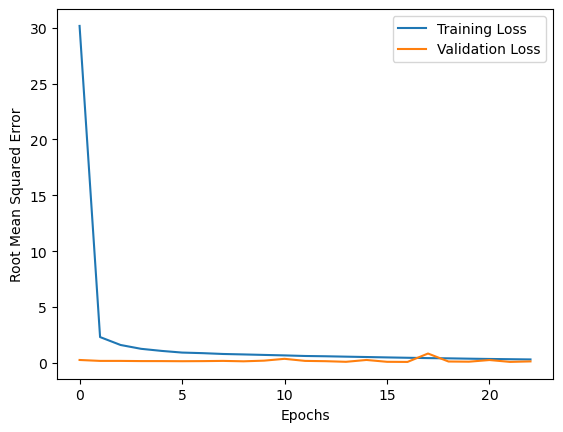

In [34]:

# Conversione dei dati in float32
x_train = x_train.astype('float32')
x_test_encoded_with_dummies = x_test_encoded_with_dummies.astype('float32')

# Split del training set in training e validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Costruzione del modello con dropout e early stopping
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='mean_squared_error')

# Definizione della callback di early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Addestramento del modello con early stopping
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

# Valutazione del modello sul set di test
mse_test = model.evaluate(x_test_encoded_with_dummies, y_test_log)
print(f'Test MSE: {mse_test}')
rmse = np.sqrt(mse_test)
print("Test Set - RMSE:", rmse)

# Predizione sul set di test
y_pred_test = model.predict(x_test_encoded_with_dummies)

# Plot della loss sul training set e sul validation set
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()
